In [1]:
# Basic libraries
import pandas as pd
import matplotlib.pyplot as plt

# Classification models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, Perceptron, SGDClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

# Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Utilities and metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Exploração do Dataset

In [2]:
path = "../data/binary/"
df = pd.read_csv(path + 'IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## Preprocessamento do Dataset

In [4]:
df = df.groupby('sentiment').apply(lambda x: x.sample(frac=0.1)).reset_index(drop=True)
df['sentiment'].value_counts()

C:\Users\Rafael\AppData\Local\Temp\ipykernel_15308\416452691.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('sentiment').apply(lambda x: x.sample(frac=0.1)).reset_index(drop=True)


sentiment
negative    2500
positive    2500
Name: count, dtype: int64

## Divisão do Dataset em treino e teste

In [5]:
features = df['review']
target = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=421)

## Definição dos vetorizadores, modelos e parâmetros para o GridSearch

In [6]:
vectorizers = [
    TfidfVectorizer(),
    CountVectorizer()
]

param_grids = [
    {
        'vectorizer': vectorizers,
        'classifier': [SVC()],
        'classifier__C': [1, 10],
        'classifier__kernel': ['linear', 'rbf']
    },
    {
        'vectorizer': vectorizers,
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.01, 1.0]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 150, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [LogisticRegression(max_iter=1000)],
        'classifier__C': [1, 10],
        'classifier__penalty': ['l2']
    },
    {
        'vectorizer': vectorizers,
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [None, 10, 20]
    }
]

pipeline = Pipeline([
    ('vectorizer', 'passthrough'),
    ('classifier', 'passthrough')
])

## Execução do GridSearch

In [7]:
grid_search = GridSearchCV(pipeline, param_grids, cv=5, n_jobs=4, verbose=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 46 candidates, totalling 230 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', 'passthrough'),
                                       ('classifier', 'passthrough')]),
             n_jobs=4,
             param_grid=[{'classifier': [SVC()], 'classifier__C': [1, 10],
                          'classifier__kernel': ['linear', 'rbf'],
                          'vectorizer': [TfidfVectorizer(), CountVectorizer()]},
                         {'classifier': [MultinomialNB()],
                          'classifier__alpha': [0.01, 1.0],
                          'vectorizer': [TfidfVectoriz...
                          'classifier__penalty': ['l2'],
                          'vectorizer': [TfidfVectorizer(), CountVectorizer()]},
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [3, 5, 7],
                          'vectorizer': [TfidfVectorizer(), CountVectorizer()]},
                         {'classifier': [DecisionTreeClassifier()],
                          'classifier__max_depth': [None, 10, 20],
                          'vectorizer': [TfidfVectorizer(),
                                         CountVectorizer()]}],
             scoring='accuracy', verbose=3)

## Resultados finais e matriz de confusão

In [8]:
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest set classification report with best model:")
print(classification_report(y_test, y_pred, digits=4))

Best parameters found: {'classifier': LogisticRegression(max_iter=1000), 'classifier__C': 10, 'classifier__penalty': 'l2', 'vectorizer': TfidfVectorizer()}
Best cross-validation score: 0.8612500000000001

Test set classification report with best model:
              precision    recall  f1-score   support

    negative     0.8727    0.8654    0.8690       483
    positive     0.8752    0.8820    0.8786       517

    accuracy                         0.8740      1000
   macro avg     0.8739    0.8737    0.8738      1000
weighted avg     0.8740    0.8740    0.8740      1000



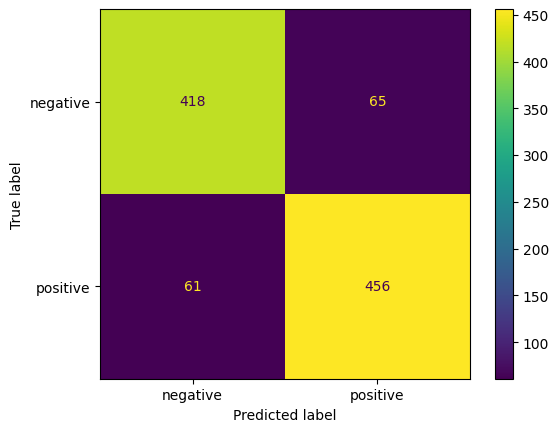

In [9]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='viridis')